- - -

#### _Extracting lineage metrics from PhysiCell output for informed ABM development._

- - -

_Citations:_

elmar bucher, godzilla-but-nicer, Randy Heiland, Paul Macklin, & Patrick G Wall. (2023). elmbeech/physicelldataloader: 2023-07-23 (v3.2.9). Zenodo. https://doi.org/10.5281/zenodo.8176400

Ghaffarizadeh, A., Heiland, R., Friedman, S. H., Mumenthaler, S. M., & Macklin, P. (2018). PhysiCell: An open source physics-based cell simulator for 3-D multicellular systems. PLoS computational biology, 14(2), e1005991.

Ghaffarizadeh, A., Friedman, S. H., & Macklin, P. (2016). BioFVM: an efficient, parallelized diffusive transport solver for 3-D biological simulations. Bioinformatics, 32(8), 1256-1258.

- - -

# Install libraries

In [36]:
# for loading PhysiCell output
## !pip3 install -U pcdl[all]

# for data visualization
## !pip3 install plotly==5.22.0
## !pip3 install pygraphviz

# for HTML output
## !pip install jinja2==3.0.3
## !pip install nbconvert==6.4.4
## !pip install pretty-jupyter 

%load_ext pretty_jupyter

The pretty_jupyter extension is already loaded. To reload it, use:
  %reload_ext pretty_jupyter


# Load libraries

In [1]:
import pcdl

import numpy as np
import pandas as pd

from sklearn.decomposition import PCA

import json

import ipykernel # for debugging
from IPython.display import display, HTML

from scipy.spatial import KDTree

import plotly.express as px
import plotly.graph_objects as go

import plotly.io as pio
pio.renderers.default = "notebook"


import networkx as nx

import collections

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation


# Load data

Output is in `../../output_ffdd1e6s_heterogeneity`.

In [2]:
# -.-|m { output: false }

output_path = "../../output_ffdd1e6_heterogeneity"

# MultiCellular Data Standard // https://www.biorxiv.org/content/10.1101/090456v2

# TimeSeries -- the entirety of the simulation
mcds_ts = pcdl.TimeSeries(output_path) 
all_mcds = mcds_ts.read_mcds()
# TimeStep -- a "snapshot" of the simulation
# mcds = pcdl.TimeStep(file_48_path)

reading: ../../output_ffdd1e6_heterogeneity/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['oncoprotein']
reading: ../../output_ffdd1e6_heterogeneity/output00000000.xml
working on metadata ...
working on mesh data ...
reading: ../../output_ffdd1e6_heterogeneity/initial_mesh0.mat
working on microenvironment data ...
reading: ../../output_ffdd1e6_heterogeneity/output00000000_microenvironment0.mat
parsing: oxygen data
working on discrete cell data ...
reading: ../../output_ffdd1e6_heterogeneity/output00000000_cells.mat
working on graph data ...
reading: ../../output_ffdd1e6_heterogeneity/output00000000_cell_neighbor_graph.txt
reading: ../../output_ffdd1e6_heterogeneity/output00000000_attached_cells_graph.txt
done!

reading: ../../output_ffdd1e6_heterogeneity/PhysiCell_settings.xml
Warning @ pyMCDS._read_xml : cell_definition custom_data without variable type setting detected. ['oncoprotein']
reading: ../../output_ff

In [8]:
mcds_140 = all_mcds[140]

print(mcds_140.get_time())

8400.0


# Prepare data

In [9]:
# variables that have only 1 state carry no information, 
# so output variables with at least 2 states

df_cell = mcds_140.get_cell_df(states=2)

In [10]:
display(df_cell)

,cell_count_voxel,cell_density_micron3,current_cycle_phase_exit_rate,current_death_model,current_phase,cycle_model,cytoplasmic_biomass_change_rate,cytoplasmic_volume,dead,death_rates_1,...,surface_area,target_fluid_fraction,target_solid_cytoplasmic,target_solid_nuclear,time,total_volume,tree_ID,voxel_i,voxel_j,voxel_k
ID,,,,,,,,,,,,,,,,,,,,,
0,3,0.000375,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,317.986883,True,9.000000e+99,...,225.297789,0.00,0.0,0.0,8400.0,317.986884,0.0,49,49,0
1,1,0.000125,0.000012,1,necrotic_lysed,necrosis_death_model,0.000053,317.986883,True,9.000000e+99,...,225.297789,0.00,0.0,0.0,8400.0,317.986884,1.0,50,50,0
2,3,0.000375,0.000004,0,live,live_cells_cycle_model,0.004500,1954.000000,False,0.000000e+00,...,889.368528,0.75,488.5,135.0,8400.0,2494.000000,2.0,49,49,0
3,3,0.000375,0.000003,0,live,live_cells_cycle_model,0.004500,1954.000000,False,0.000000e+00,...,889.368528,0.75,488.5,135.0,8400.0,2494.000000,3.0,51,49,0
1076,1,0.000125,0.000132,0,live,live_cells_cycle_model,0.004500,1954.000000,False,0.000000e+00,...,889.368528,0.75,488.5,135.0,8400.0,2494.000000,1076.3,53,36,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1355,1,0.000125,0.000131,0,live,live_cells_cycle_model,0.004500,1112.874365,False,0.000000e+00,...,614.116200,0.75,488.5,135.0,8400.0,1431.032984,1355.2,64,54,0
1356,2,0.000250,0.000132,0,live,live_cells_cycle_model,0.004500,1098.338160,False,0.000000e+00,...,608.561027,0.75,488.5,135.0,8400.0,1411.659703,1356.4,52,62,0
1357,1,0.000125,0.000147,0,live,live_cells_cycle_model,0.004500,1020.558890,False,0.000000e+00,...,577.963752,0.75,488.5,135.0,8400.0,1306.546034,1357.2,36,46,0


In [13]:
df_cell = df_cell.astype({"generation": int})
df_cell = df_cell[["generation", "tree_ID", "parent_ID"]].sort_index()
display(df_cell)


,generation,tree_ID,parent_ID
ID,,,
0,0,0.0,-1.0
1,0,1.0,-1.0
2,0,2.0,-1.0
3,0,3.0,-1.0
5,0,5.0,-1.0
...,...,...,...
1357,2,1357.2,1037.1
1358,2,1358.2,323.1
1359,1,1359.1,740.0


In [19]:
unique_tree_IDs = df_cell["tree_ID"].unique()
np.set_printoptions(suppress=True)
unique_tree_IDs

array([   0. ,    1. ,    2. ,    3. ,    5. ,    6. ,    7. ,    8. ,
          9. ,   13. ,   15. ,   16. ,   17.1,   20. ,   23. ,   25. ,
         26. ,   27. ,   28.2,   29. ,   30.2,   31. ,   33. ,   34. ,
         35. ,   36. ,   37. ,   38. ,   39. ,   41. ,   42. ,   45. ,
         48. ,   49. ,   51. ,   52.1,   53. ,   54. ,   55.1,   56. ,
         58. ,   62. ,   63. ,   64. ,   65.2,   66. ,   67. ,   70. ,
         72.1,   75. ,   76.2,   80. ,   81.2,   82.1,   83. ,   84.3,
         85. ,   87. ,   88.1,   91.3,   93. ,   94. ,   95. ,   96. ,
         97. ,   98. ,  100. ,  101. ,  102. ,  103. ,  104. ,  105. ,
        106. ,  109. ,  110. ,  111. ,  112. ,  117. ,  118. ,  119. ,
        123.1,  125. ,  126. ,  127. ,  128.1,  129.2,  130. ,  131.1,
        132.1,  137.1,  139. ,  140. ,  141.1,  142. ,  143. ,  144.1,
        145. ,  146.1,  147. ,  148. ,  149. ,  150.2,  151. ,  153.1,
        154.1,  157.1,  160. ,  161. ,  162. ,  163. ,  164. ,  165. ,
      

In [34]:
ad = []

for timestep in all_mcds:
    time = timestep.data['metadata']['current_time']
    df = timestep.get_cell_df()
    df = df.loc[(df['parent_ID'] >= 0.0) & (df['parent_ID'] <= 50.0)]
    df['time'] = time
    ad.append(df)

select_cells_lineage = pd.concat(ad)
display(select_cells_lineage)

,attachment_elastic_constant,attachment_rate,calcification_rate,calcified_fraction,cancer_cell_attack_rates,cancer_cell_cell_adhesion_affinities,cancer_cell_fusion_rates,cancer_cell_live_phagocytosis_rates,cancer_cell_transformation_rates,cell_BM_adhesion_strength,...,total_attack_time,total_volume,tree_ID,velocity_vectorlength,velocity_x,velocity_y,velocity_z,voxel_i,voxel_j,voxel_k
ID,,,,,,,,,,,,,,,,,,,,,
10,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1255.82,10.10,0.00,0.00,0.00,0.00,46,50,0
24,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1255.82,24.10,0.00,0.00,0.00,0.00,40,50,0
943,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1255.82,943.10,0.00,0.00,0.00,0.00,45,49,0
944,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1255.82,944.10,0.00,0.00,0.00,0.00,40,49,0
10,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,1411.66,10.10,0.00,0.00,0.00,0.00,46,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,2494.00,943.10,0.00,0.00,0.00,0.00,45,49,0
948,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,2494.00,948.20,0.00,0.00,0.00,0.00,40,50,0
961,0.01,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,4.00,...,0.00,2494.00,961.10,0.00,0.00,0.00,0.00,38,49,0


In [32]:
# color_dict = {"bacteria": "grey", "blood_vessel": "red", "stem": "yellow", "differentiated": "green", "macrophage": "blue", "CD8+_T_cell": "magenta", "neutrophil": "orange"}

def create_cell_ancestry(df):
    df = df.drop(df.loc[df['parent_ID'] == -1, 'parent_ID'].index)

    G = nx.from_pandas_edgelist(df, source='parent_ID', target='tree_ID', create_using=nx.DiGraph())

    pos = nx.drawing.nx_agraph.graphviz_layout(G, prog='dot')
    nx.draw(G, pos, with_labels=True, arrows=True, node_color="lightblue")

    # T = nx.draw_spring(G, node_size=5, with_labels=True)

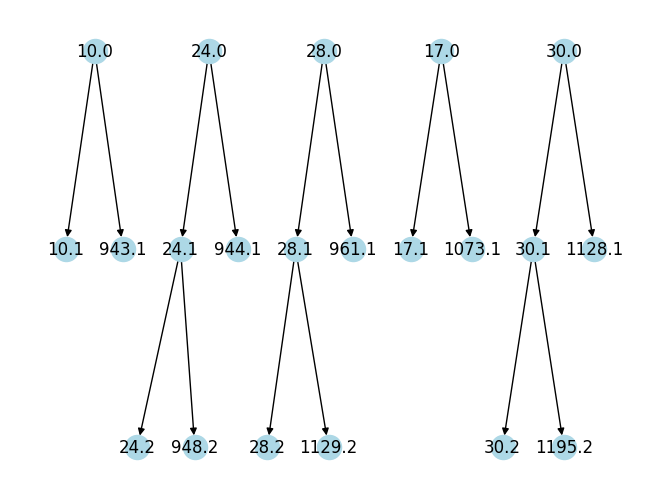

In [35]:
create_cell_ancestry(select_cells_lineage.copy())

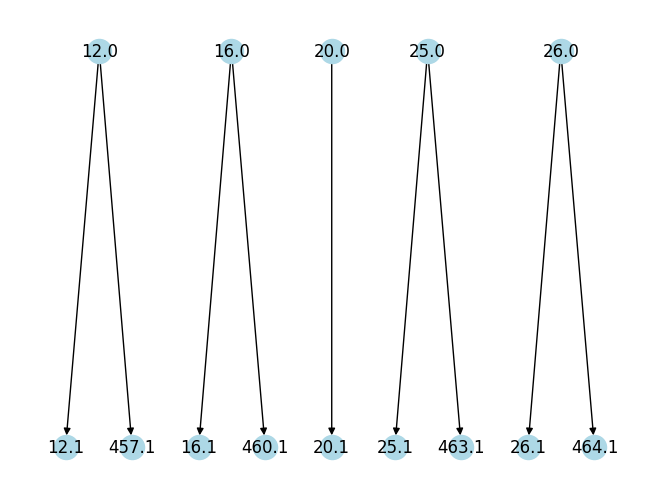

In [85]:
# create_cell_ancestry(large.copy())

# large['ID'] = large.index
# print(large.loc[(large['parent_ID'] == 16.0) | (large['parent_ID'] == 16.1)])

l = df_cell_large.copy()
l = l.loc[(l['parent_ID'] >= 10.0) & (l['parent_ID'] <= 30.0)]

create_cell_ancestry(l)

In [17]:
# fig, ax = plt.subplots()

# def animate(i): 
#     ax.clear()
    
#     timestep = all_mcds[i]
#     timestep_cell_df = timestep.get_cell_df()
    
#     timestep_cell_df["ID"] = timestep_cell_df.index.copy()

#     timestep_cell_df["cell_color"] = timestep_cell_df.apply(lambda row: color_dict[row.cell_type], axis = 1)
#     timestep_cell_df.loc[timestep_cell_df['parent_ID'] == -1, 'parent_ID'] = None

#     G = nx.from_pandas_edgelist(timestep_cell_df, source='parent_ID', target='ID', create_using=nx.DiGraph())
#     nx.set_node_attributes(G, timestep_cell_df.set_index('ID').to_dict('index'))

#     colors = []
#     for node in list(G.nodes()):
#         try:
#             colors.append(G.nodes[node]["cell_color"])
#         except:
#             colors.append("black")

#     nx.draw_spring(G, node_size=5, node_color=colors)
    
# anim = animation.FuncAnimation(fig, animate, frames=len(all_mcds), interval=1)

# writer = animation.PillowWriter(fps=15,
#                                 metadata=dict(artist='Me'),
#                                 bitrate=1800)
# anim.save('graph_anim.gif', writer=writer)

# Creating a lineage plot from a cell dataframe

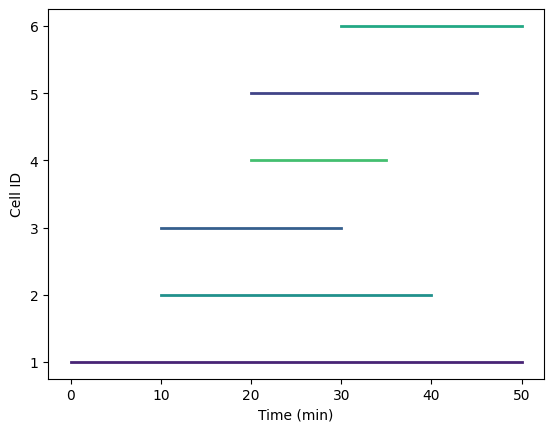

In [84]:
# Gantt chart (used for timelines / schedules) https://plotly.com/python/gantt/

# example
data = {
    'cell_id': [1, 2, 3, 4, 5, 6],
    'birth_time': [0, 10, 10, 20, 20, 30],
    'death_time': [50, 40, 30, 35, 45, 50],
    'feature': [0.1, 0.5, 0.3, 0.7, 0.2, 0.6]
}

df = pd.DataFrame(data)

fig, ax = plt.subplots()

for i, row in df.iterrows():
    ax.plot([row['birth_time'], row['death_time']], [i, i], color=plt.cm.viridis(row['feature']), lw=2) # discrete color scale (not suitable for continuous values)

ax.set_xlabel('Time (min)')
ax.set_ylabel('Cell ID')
ax.set_yticks(range(len(df)))
ax.set_yticklabels(df['cell_id'])

plt.show()

'''
NOTES

This only works / looks visually correct if the cell IDs are tailored such that they are
consecutive, or at least numerically ascending.

No parent ID taken into account.
'''


,ID,parent_ID,birth_time,death_time,density
0,1,-1,0,50,0.1
1,2,1,10,40,0.2
2,3,1,10,30,0.2
3,4,2,20,35,0.5
4,5,2,20,45,0.4
5,6,3,30,50,0.8
6,7,3,30,70,0.8


/var/folders/hb/6dk2l2613ngc433vnd63bg1r0000gn/T/ipykernel_37992/1172469406.py:32: UserWarning:

color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.



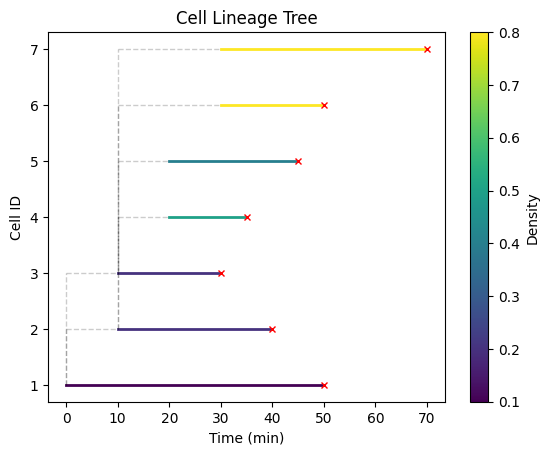

In [144]:
# example - with parent ID
data = {
    'ID': [1, 2, 3, 4, 5, 6, 7],
    'parent_ID': [-1, 1, 1, 2, 2, 3, 3],
    'birth_time': [0, 10, 10, 20, 20, 30, 30],
    'death_time': [50, 40, 30, 35, 45, 50, 70],
    'density': [0.1, 0.2, 0.2, 0.5, 0.4, 0.8, 0.8]
}

df = pd.DataFrame(data)
display(df)

# assign unique y positions
df['y_pos'] = range(1, len(df) + 1)

fig, ax = plt.subplots()

# color map for continuous feature of the data (ex. spatial metrics)
cmap = plt.cm.viridis
norm = matplotlib.colors.Normalize(vmin=df['density'].min(), vmax=df['density'].max())

colors = {}

# recursive plot of branches
# include y position, y step, so each cell is on its own "line" / position on the plot
def plot_branch(cell_id, parent_id, birth_time, death_time, y_pos):
    feature_value = df.loc[df['ID'] == cell_id]['density'].values[0]
    
    color = cmap(norm(feature_value))
    colors[cell_id] = color

    ax.plot([birth_time, death_time], [y_pos, y_pos], 'k-', color=color, lw=2) # span of a cell's life
    ax.plot([birth_time, death_time], [y_pos, y_pos], 'rx', markevery=[-1], markersize=5) # death

    # cells with parent ID -1 are cells that existed at the beginning of the simulation...
    # ...and thus do not have any parents/ancestors

    if parent_id != -1: 
        parent_birth_time = df.loc[df['ID'] == parent_id]['birth_time'].values[0]
        parent_y_pos = df.loc[df['ID'] == parent_id]['y_pos'].values[0]

        # connection from parent to child
        ax.plot([parent_birth_time, parent_birth_time], [parent_y_pos, y_pos], 'k--', alpha=0.2, lw=1) # vertical
        ax.plot([parent_birth_time, birth_time], [y_pos, y_pos], 'k--', alpha=0.2, lw=1) # horizontal

for row in df.itertuples():
    plot_branch(row.ID, row.parent_ID, row.birth_time, row.death_time, row.y_pos)

ax.set_xlabel('Time (min)')
ax.set_ylabel('Cell ID')
ax.set_title('Cell Lineage Tree')

# legend
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('Density')

plt.show()